In [50]:
import os
import json
import numpy as np
from tifffile import imread
import cv2
import skimage.io as sio

import albumentations as A
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection import MaskRCNN, FasterRCNN_ResNet50_FPN_Weights, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models import ResNet50_Weights
from torchvision.ops import box_convert
import torchvision.transforms as T
import torch.nn.functional as F

import torch
from torch.optim import SGD, lr_scheduler

import pathlib
import json

from tqdm.auto import tqdm
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from pycocotools.cocoeval import COCOeval

from PIL import Image

from matplotlib import pyplot as plt

In [51]:
# !gdown https://drive.google.com/file/d/1B0qWNzQZQmfQP7x7o4FDdgb9GvPDoFzI/view --fuzzy
# !mkdir ../dataset
# !tar -xzf hw3-data-release.tar.gz
# !mv test_release/ ../dataset
# !mv train/ ../dataset/
# !mv test_image_name_to_ids.json ../dataset/

In [52]:
import numpy as np
import skimage.io as sio
from pycocotools import mask as mask_utils


def decode_maskobj(mask_obj):
    return mask_utils.decode(mask_obj)


def encode_mask(binary_mask):
    arr = np.asfortranarray(binary_mask).astype(np.uint8)
    rle = mask_utils.encode(arr)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle


def read_maskfile(filepath):
    mask_array = sio.imread(filepath)
    return mask_array

In [53]:
all_img_size = [224, 224]

In [54]:
class MedicalDataset(Dataset):
    def __init__(self, root_dir, transform=None, data_type='Train'):
        self.root = root_dir
        self.transform = transform
        self.data_type = data_type
        if self.data_type not in ['Train', 'Valid', 'Test']:
            raise ValueError('Data type should be in [Train, Valid, Test]')
        self.samples = self._load_samples()

        self.train_coco_path = os.path.join(pathlib.Path(root_dir).parent, 'train_coco.json')
        self.val_coco_path = os.path.join(pathlib.Path(root_dir).parent, 'val_coco.json')
        self.test_json_path = os.path.join(pathlib.Path(root_dir).parent, 'test_image_name_to_ids.json')

        if not os.path.exists(self.train_coco_path) or not os.path.exists(self.val_coco_path):
            # self.generate_coco_split_new(self.train_coco_path, self.val_coco_path, split_ratio=0.8)
            self.generate_coco_split(self.train_coco_path, self.val_coco_path, split_ratio=0.8)
        self.train_coco = COCO(self.train_coco_path)
        self.val_coco = COCO(self.val_coco_path)

        self.num_classes = len(self.train_coco.loadCats(self.train_coco.getCatIds()))

    def _load_samples(self):
        samples = []
        for img_dir in os.listdir(self.root):
            tmp_dir = os.path.join(self.root, img_dir)

            if self.data_type == 'Train' or self.data_type == 'Valid':
                img_path = os.path.join(tmp_dir, 'image.tif')

                mask_paths = [
                    entry.name for entry in pathlib.Path(tmp_dir).iterdir()
                    if entry.name.startswith("class") and entry.is_file()
                ]

                samples.append({'image': img_path, 'masks': mask_paths})
            elif self.data_type == 'Test':
                test_img_json_path = os.path.join(pathlib.Path(self.root).parent, 'test_image_name_to_ids.json')
                with open(test_img_json_path, 'r') as f:
                    samples = json.load(f)

            else:
                raise ValueError('Wrong data type')

                # for idx in range(len(samples)):
                #     samples[idx]['file_name'] = os.path.join(self.root, samples[idx]['file_name'])
        return samples

    def mask_to_polygons(self, mask, epsilon=1.0):
        contours,_ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for contour in contours:
            if len(contour) > 2:
                poly = contour.reshape(-1).tolist()
                if len(poly) > 4: #Ensures valid polygon
                    polygons.append(poly)
        return polygons


    # 全都改transform後的結果
    def generate_coco_split_new(self, train_coco_path, val_coco_path, split_ratio=0.8):
        train_data = {"images": [], "annotations": [], "categories": []}
        val_data = {"images": [], "annotations": [], "categories": []}
        all_labels = []
        ann_id = 0
        train_ann = 0
        val_ann = 0

        # 隨機分離樣本索引
        indices = list(range(len(self.samples)))
        import random
        seed = 123
        random.Random(seed).shuffle(indices)
        split_point = int(len(indices) * split_ratio)
        train_indices = indices[:split_point]
        val_indices = indices[split_point:]

        for dataset_type, indices in [("train", train_indices), ("val", val_indices)]:
            target_data = train_data if dataset_type == "train" else val_data

            for idx in indices:
                sample = self.samples[idx]
                img_path, mask_paths = sample['image'], sample['masks']
                img = cv2.imread(img_path)
                masks = [cv2.imread(os.path.join(pathlib.Path(img_path).parent, mask_path), cv2.IMREAD_UNCHANGED) for mask_path in mask_paths]

                image_entry = {
                    "id": idx,
                    "file_name": img_path,
                    "height": all_img_size[0],
                    "width": all_img_size[1]
                }
                target_data["images"].append(image_entry)

                for mask in masks:
                    unique_values = np.unique(mask)
                    # all_labels.append(unique_values)
                    for value in unique_values:
                        if value == 0:  # Ignore background
                            continue

                        mask_ = cv2.resize(
                            mask,
                            (all_img_size[1], all_img_size[0]),
                            interpolation=cv2.INTER_NEAREST_EXACT  # 精確最近鄰算法
                        )

                        object_mask = (mask_ == value).astype(np.uint8) * 255
                        polygons = self.mask_to_polygons(object_mask)

                        for poly in polygons:
                            # ann_id += 1
                            if dataset_type == 'train':
                                train_ann += 1
                                ann_id = train_ann
                            else:
                                val_ann += 1
                                ann_id = val_ann

                            target_data["annotations"].append({
                                "id": ann_id,
                                "image_id": idx,
                                # "category_id": int(value),  # Only one category: Nuclei
                                "category_id": 1,  # Only one category: Nuclei
                                "segmentation": [poly],
                                "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                                "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                                "iscrowd": 1
                            })

        # all_labels = np.unique(np.concatenate(all_labels).tolist())

        categories = [{"id": 1, "name": "Nuclei"}]
        for idx, label in enumerate(all_labels):
            categories.append({"id": idx+1, "name": int(label)})
        # categories = []
        # for i in range(0, 4):
        #     categories.append({"id": i, "name": i})
        train_data["categories"] = categories
        val_data["categories"] = categories


        # coco_input = {
        #     "images": images,
        #     "annotations": annotations,
        #     "categories": categories
        # }

        print(f'Saving coco json')

        with open(train_coco_path, 'w') as f:
            json.dump(train_data, f)
        with open(val_coco_path, 'w') as f:
            json.dump(val_data, f)

    def generate_coco_split(self, train_coco_path, val_coco_path, split_ratio=0.8):
        train_data = {"images": [], "annotations": [], "categories": []}
        val_data = {"images": [], "annotations": [], "categories": []}
        all_labels = []
        ann_id = 0
        train_ann = 0
        val_ann = 0

        # 隨機分離樣本索引
        indices = list(range(len(self.samples)))
        import random
        seed = 123
        random.Random(seed).shuffle(indices)
        split_point = int(len(indices) * split_ratio)
        train_indices = indices[:split_point]
        val_indices = indices[split_point:]

        for dataset_type, indices in [("train", train_indices), ("val", val_indices)]:
            target_data = train_data if dataset_type == "train" else val_data

            for idx in indices:
                sample = self.samples[idx]
                img_path, mask_paths = sample['image'], sample['masks']
                img = cv2.imread(img_path) # [H, W, C]
                masks = [cv2.imread(os.path.join(pathlib.Path(img_path).parent, mask_path), cv2.IMREAD_UNCHANGED) for mask_path in mask_paths]

                image_entry = {
                    "id": idx,
                    "file_name": img_path,
                    "height": img.shape[0],
                    "width": img.shape[1]
                }
                target_data["images"].append(image_entry)

                for mask_path in mask_paths:
                    import re
                    m = re.search(r"class(\d+)\.tif", mask_path)
                    class_ = int(m.group(1))
                # for mask in masks:
                    mask = sio.imread(os.path.join(pathlib.Path(img_path).parent, mask_path))
                    unique_values = np.unique(mask)
                    # all_labels.append(unique_values)
                    for value in unique_values:
                        if value == 0:  # Ignore background
                            continue

                        object_mask = (mask == value).astype(np.uint8)
                        # object_mask = (img == value).astype(np.uint8) * 255#.copy()
                        # ys, xs = np.where(object_mask)
                        # x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()

                        rle = encode_mask(object_mask)
                        # rle = mask_utils.encode(np.asfortranarray(object_mask))
                        # print(rle)
                        polygons = self.mask_to_polygons(object_mask)
                        # print(rle)
                        # for i in rle:
                        #     if i != rle[0]:
                        #         raise ValueError('not all rle the same')
                        # rle = rle[0]
                        # rle['counts'] = rle['counts'].decode('utf-8')

                        for poly in polygons:
                            # print(f'len of poly: {len(polygons)}')
                            # ann_id += 1

                        # contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                            bbox = list(cv2.boundingRect(np.array(poly).reshape(-1, 2)))
                            # TEST XYXY BBOX
                            # bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]

                            # TEST XYWH BBOX
                            bbox = bbox


                            # print(bbox)
                            # for cnt in contours:
                            #     x, y, w, h = cv2.boundingRect(cnt)
                            #     x1, y1, x2, y2 = x, y, x+w, y+h
                            #     bbox.append([x1, y1, x2, y2])
                            # if dataset_type == 'train':
                            #     train_ann += 1
                            #     ann_id = train_ann
                            # else:
                            #     val_ann += 1
                            #     ann_id = val_ann

                            target_data["annotations"].append({
                                # "id": ann_id,
                                "id": len(target_data["annotations"])+1,
                                "image_id": idx,
                                # "category_id": int(value),  # Only one category: Nuclei
                                "category_id": class_,  # Only one category: Nuclei
                                # "segmentation": [poly],
                                "segmentation": rle,
                                "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                                # "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                                "bbox": bbox,   # xyxy
                                "iscrowd": 1
                            })

        # all_labels = np.unique(np.concatenate(all_labels).tolist())

        # categories = [{"id": 1, "name": "Nuclei"}]
        # # for idx, label in enumerate(all_labels):
        # #     categories.append({"id": idx+1, "name": int(label)})
        categories = []
        for i in range(1, 5):
            categories.append({"id": i, "name": i})
        train_data["categories"] = categories
        val_data["categories"] = categories


        # coco_input = {
        #     "images": images,
        #     "annotations": annotations,
        #     "categories": categories
        # }

        print(f'Saving coco json')

        with open(train_coco_path, 'w') as f:
            json.dump(train_data, f)
        with open(val_coco_path, 'w') as f:
            json.dump(val_data, f)


    def poly2mask(self, segmentation, img_size):
        """
        多邊形標註轉二值掩碼
        :param segmentation: COCO格式的多邊形坐標列表 [[x1,y1,x2,y2,...]]
        :param img_size: 目標圖像尺寸 (height, width)
        """
        # 自動檢測標註類型
        if isinstance(segmentation, dict):
            # 處理RLE格式
            return coco_mask.decode(segmentation)
        else:
            # 處理多邊形格式
            rle = coco_mask.frPyObjects(segmentation, img_size[0], img_size[1])
            return coco_mask.decode(rle)

    # New get item
    def __getitem__(self, index):
        if self.data_type == 'Train' or self.data_type == 'Valid':
            coco_file = self.train_coco if self.data_type == 'Train' else self.val_coco
            img_id = coco_file.dataset['images'][index]['id']
            img_ids = coco_file.getImgIds(imgIds=img_id)
            img_info = coco_file.loadImgs(img_ids)
            image = cv2.imread(img_info[0]['file_name'])# / 255.0
            # print(img_info)
            # image = Image.open(img_info[0]['file_name']).convert("RGB")
            image = self.transform(image) if self.transform is not None else image

            img_size = [img_info[0]['height'], img_info[0]['width']]
            # img_size = [image.shape[1], image.shape[2]]


            boxes = []
            masks = []
            labels = []
            ann_ids = coco_file.getAnnIds(imgIds=img_ids)
            annotations = coco_file.loadAnns(ann_ids)
            for ann in annotations:
                boxes.append(ann['bbox'])
                tmp_mask = self.poly2mask(ann['segmentation'], img_size).squeeze()

                tmp_mask = cv2.resize(
                    tmp_mask,
                    (all_img_size[1], all_img_size[0]),
                    interpolation=cv2.INTER_NEAREST_EXACT  # 精確最近鄰算法
                )

                masks.append(tmp_mask)
                labels.append(ann["category_id"])

            # boxes = self.resize_box(boxes, img_size, target_size=all_img_size)
            boxes = box_convert(torch.tensor(boxes, dtype=torch.float32), in_fmt='xywh', out_fmt='xyxy')
            # masks = torch.as_tensor(np.array(masks), dtype=torch.bool)

            scale_h = all_img_size[0] / img_size[0]
            scale_w = all_img_size[1] / img_size[1]
            boxes[:, 0] *= scale_w
            boxes[:, 1] *= scale_h
            boxes[:, 2] *= scale_w
            boxes[:, 3] *= scale_h

            target = {'boxes': boxes,
                      'masks': torch.as_tensor(np.array(masks), dtype=torch.bool),
                      'labels': torch.as_tensor(np.array(labels), dtype=torch.int64)}

            return img_id, image, target # box -> xyxy
        else:
            test_file=[]
            with open(self.test_json_path, 'r') as f:
                test_file = json.load(f)

            image_id = test_file[index]['id']

            image_path = os.path.join(self.root, test_file[index]['file_name'])
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)

            return image_id, image
            raise ValueError('This is test, not yet implement')

    def resize_box(self, boxes, orig_size, target_size):
        # Eat xywh
        scale_w = target_size[1] / orig_size[1]
        scale_h = target_size[0] / orig_size[0]

        # print(f'scale_w = {target_size[1]} / {orig_size[1]}')
        # print(f'scale_h = {target_size[0]} / {orig_size[0]}')

        # print(f'boxes: {boxes}')
        for box in boxes:
            box[0] *= scale_w  # x
            box[1] *= scale_h  # y
            box[2] *= scale_w  # w
            box[3] *= scale_h  # h
        # boxes[:,0] *= scale_w  # x
        # boxes[:,1] *= scale_h  # y
        # boxes[:,2] *= scale_w  # w
        # boxes[:,3] *= scale_h  # h

        return boxes

    def __len__(self):
        coco_file = self.train_coco if self.data_type == 'Train' else self.val_coco
        return len(coco_file.dataset['images'])

In [55]:
project_root = '..'
train_dir = os.path.join(project_root, 'dataset/train')
val_dir = train_dir
test_dir = os.path.join(project_root, 'dataset/test_release')

In [56]:
# train_transform=T.Compose([
#     T.ToTensor(),
#     T.Resize(size=all_img_size, antialias=True),
#     # T.CenterCrop(size=224),
#     # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
# train_set = MedicalDataset(root_dir=train_dir, transform=train_transform, data_type='Train')

# print(train_set[0])

In [57]:
# train_transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.3),
#     A.Rotate(limit=15, p=0.4),
#     A.CLAHE(p=0.5),
#     A.GridDistortion(p=0.2),
#     A.RandomBrightnessContrast(p=0.3)
# ], additional_targets={'mask': 'mask'})
train_transform=T.Compose([
    T.ToTensor(),
    T.Resize(size=all_img_size, antialias=True),
    # T.CenterCrop(size=224),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = train_transform

train_set = MedicalDataset(root_dir=train_dir, transform=train_transform, data_type='Train')
val_set = MedicalDataset(root_dir=val_dir, transform=val_transform, data_type='Valid')
sample = train_set[0]
id = sample[0]
img = sample[1]
masks = sample[2]['masks']
boxes = sample[2]['boxes']
print(f'id: {id}')
print(f'img: {img.shape}')
print(f'mask: {masks.shape}')
print(f'box: {boxes, boxes.shape}')


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
id: 98
img: torch.Size([3, 224, 224])
mask: torch.Size([763, 224, 224])
box: (tensor([[196.1226,  81.5543, 198.5041,  84.8457],
        [196.4028,  67.2914, 199.2045,  70.9486],
        [208.1701,  80.0914, 211.5322,  83.0171],
        ...,
        [128.3202,  18.1029, 133.2233,  21.2114],
        [164.7430,   0.3657, 168.8055,   3.1086],
        [ 48.3302, 210.1029,  51.1320, 213.0286]]), torch.Size([763, 4]))


In [9]:
import matplotlib.patches as patches
def show_image_with_boxes_and_masks(img, boxes, box_mode,  masks, title=''):
    """
    img: Tensor [3, H, W]
    boxes: Tensor [N, 4]
    masks: Tensor [N, H, W]
    """
    # 轉成 NumPy 格式並調整 shape 為 [H, W, 3]
    img_np = img.cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    img_np = np.clip(img_np, 0, 1)  # 正規化範圍

    plt.figure(figsize=(10, 10))
    plt.imshow(img_np)
    ax = plt.gca()

    num_objects = boxes.shape[0]
    for i in range(num_objects):
        # 畫邊界框
        if box_mode == 'xyxy':
            x1, y1, x2, y2 = boxes[i].cpu().numpy()
            w, h = x2 - x1, y2 - y1
        elif box_mode == 'xywh':
            x1, y1, w, h = boxes[i].cpu().numpy()
        else:
            raise ValueError('show image wrong box mode')
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # 畫遮罩
        mask = masks[i].cpu().numpy()
        ax.imshow(np.ma.masked_where(mask == 0, mask), cmap='cool', alpha=0.5)

    # plt.axis('off')
    plt.title(title)
    plt.show()


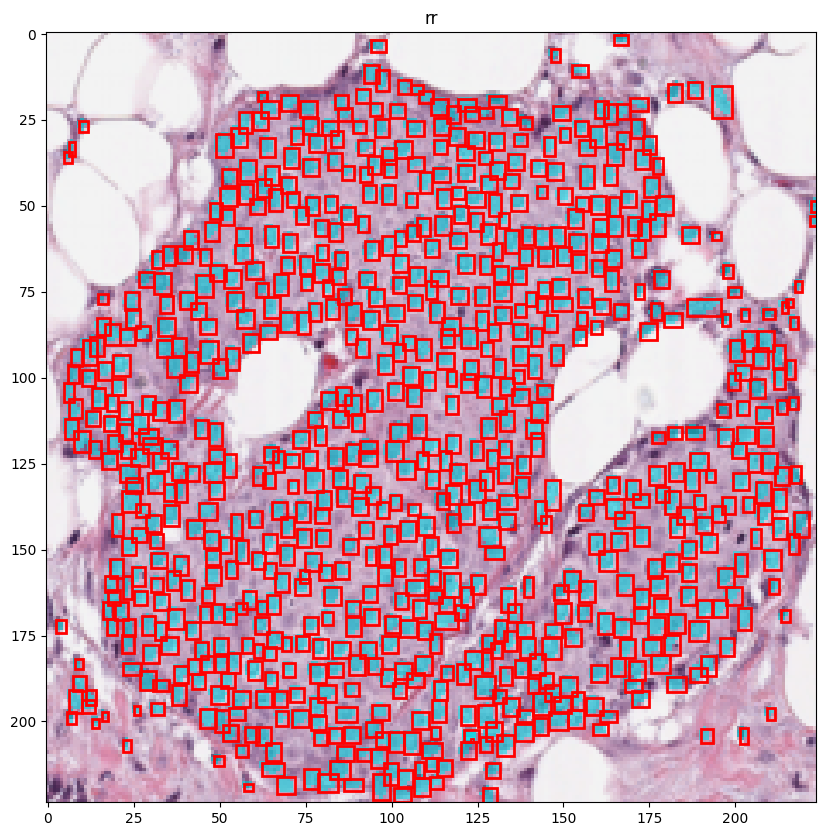

In [59]:
# img = T.ToTensor()(img)
# masks = torch.tensor(masks)
# boxes = torch.tensor(boxes)

show_image_with_boxes_and_masks(img, boxes, 'xyxy', masks, 'rr')

In [10]:
def json_check_maskonimg(cc, idx, mode=None, box_mode=None):
    if mode == 'val':
        # cc = COCO('/home/bhg/visual_dl/lab3/dataset/val_coco.json')
        imgAnn=cc.dataset['annotations'][idx]
        imgid=imgAnn['image_id']
        img_info=cc.loadImgs(imgid)[0]
        # print(img_info)
    elif mode == 'test':
        imgid=cc[idx]['image_id']
    elif mode == 'val_on_eval':
        coco=COCO('/home/bhg/visual_dl/lab3/dataset/val_coco.json')
        target=cc[idx]
        print(target)
        imgid=target['image_id']
        img_info=coco.loadImgs(imgid)[0]
        imgAnn=target
        print(f'ann: {imgAnn}')
    else:
        raise ValueError('json check mask on img wrong mode')
    imgpath=img_info['file_name']
    # print(imgpath)
    img=cv2.imread(imgpath)
    # print(img.shape)
    imgtensor=T.ToTensor()(img)
    # print(imgtensor.shape)
    box=imgAnn['bbox']
    # print(f'before box: {box}')
    boxtensor=torch.tensor([imgAnn['bbox']])
    print(f'box: {boxtensor}')
    seg=imgAnn['segmentation']
    mask=torch.tensor([decode_maskobj(seg)])
    # print(mask.shape)

    show_image_with_boxes_and_masks(imgtensor, boxtensor, box_mode, mask, 'rr')

In [ ]:
imgid = 98
cc=COCO('../dataset/train_coco.json')
img_info=cc.loadImgs(imgid)[0]
print(img_info)
imgAnn=cc.loadAnns(cc.getAnnIds(imgid))
print(imgAnn)

imgpath=img_info['file_name']
# print(imgpath)
img=cv2.imread(imgpath)
# print(img.shape)
imgtensor=T.ToTensor()(img)
# print(imgtensor.shape)
box=[b['bbox'] for b in imgAnn]
# print(f'before box: {box}')
boxtensor=torch.tensor(box)
print(f'box: {boxtensor.shape}')
seg=[decode_maskobj(b['segmentation']) for b in imgAnn]
mask=torch.tensor(seg)
print(mask.shape)

show_image_with_boxes_and_masks(imgtensor, boxtensor, 'xywh', mask, 'rr')

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
{'id': 98, 'file_name': '../dataset/train/037469cf-3ac2-409c-bf4f-55c68e9489ba/image.tif', 'height': 1225, 'width': 1599}
[{'id': 1, 'image_id': 98, 'category_id': 2, 'segmentation': {'size': [1225, 1599], 'counts': 'nW[d18oU13M2N3O0O10000O1000O10001O1M3N2MVYi6'}, 'area': 223.5, 'bbox': [1400, 446, 17, 18], 'iscrowd': 1}, {'id': 2, 'image_id': 98, 'category_id': 2, 'segmentation': {'size': [1225, 1599], 'counts': 'Ub]d12TV16K4M2N2N1O1O10000O1000O1O1O2N1O1O2N3KX\\c6'}, 'area': 269.5, 'bbox': [1402, 368, 20, 20], 'iscrowd': 1}, {'id': 3, 'image_id': 98, 'category_id': 2, 'segmentation': {'size': [1225, 1599], 'counts': 'hSbg17QV13L4M10O1001O001OO1000001O000010O0001N2O1N2O1MVQZ3'}, 'area': 278.0, 'bbox': [1486, 438, 24, 16], 'iscrowd': 1}, {'id': 4, 'image_id': 98, 'category_id': 2, 'segmentation': {'size': [1225, 1599], 'counts': 'mSei16QV13N2N3N1N2O1O1O10O001O1O1O2M4JYc`1'}, 'area': 213.0, 'bbox': [1542, 

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
box: tensor([[1402,  368,   20,   20]])


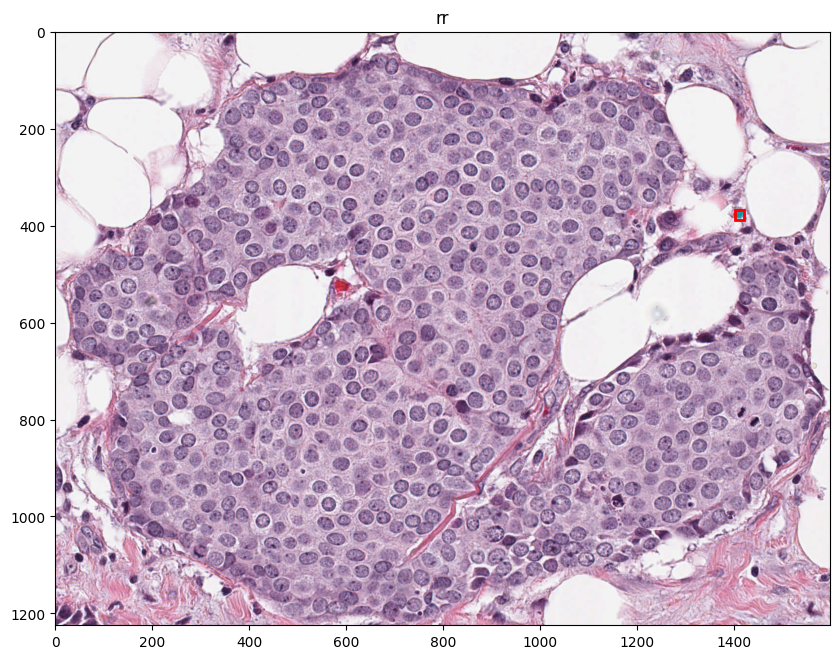

In [61]:
cc=COCO('../dataset/train_coco.json')
json_check_maskonimg(cc, 1, 'val', 'xywh')

In [12]:
# with open('../results/1_res.json', 'r') as f:
#     tt = json.load(f)
# json_check_maskonimg(tt, 606, 'val_on_eval', 'xywh')

In [13]:
max_choices = 40

# num_classes=train_set.num_classes
num_classes = 5
print(num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

def custom_collate(batch):
    img_ids = []
    images = []
    targets = []

    # print(batch[0][1])

    for img_id, img, target in batch:
        img_ids.append(img_id)
        images.append(img)
        # print(type(target['boxes']))
        keep_idx = torch.randperm(target['boxes'].shape[0])[:max_choices]
        # n = target['boxes'].shape[0]
        targets.append({
            'boxes': target['boxes'][keep_idx],
            'labels': target['labels'][keep_idx],
            'masks': target['masks'][keep_idx]
        })

    images = torch.stack(images, dim=0)
    return img_ids, images, targets


BATCH_SIZE = 4
NUM_WORKER = 4
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, persistent_workers=True, collate_fn=custom_collate, )#pin_memory='cuda' in device, pin_memory_device= device)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER, persistent_workers=True, collate_fn=custom_collate, )#pin_memory='cuda' in device, pin_memory_device= device)

5
cuda


In [14]:
def predictions_to_coco(image_ids, predictions, is_test=False, val_file_=None):
    coco_results = []
    for img_id, prediction in zip(image_ids, predictions):
        if is_test:
            test_file = []

            with open(f'../dataset/test_image_name_to_ids.json', 'r') as f:
                test_file = json.load(f)

            # print(f'img_id: {img_id}')
            img_info = test_file[img_id-1]
            # print(info)
            orig_h, orig_w = img_info['height'], img_info['width']
        else:
            val_file = val_file_

            img_info = val_file.loadImgs(img_id)
            # print(img_info)
            orig_h, orig_w = img_info[0]['height'], img_info[0]['width']
        for score, mask, label, box in zip(prediction['scores'], prediction['masks'], prediction['labels'], prediction['boxes']):
            mask = cv2.resize(
                    mask.squeeze().detach().cpu().numpy(),
                    (orig_w, orig_h),
                    interpolation=cv2.INTER_NEAREST_EXACT  # 精確最近鄰算法
                )

            rle = encode_mask(mask)

            box_convert(box, in_fmt='xyxy', out_fmt='xywh')

            scale_h = orig_h / all_img_size[0]
            scale_w = orig_w / all_img_size[1]
            box[0] *= scale_w
            box[1] *= scale_h
            box[2] *= scale_w
            box[3] *= scale_h

            coco_results.append({
                "image_id": int(img_id),
                "bbox": box.tolist(),
                "score": score.item(),
                "category_id": label.item(),
                "segmentation": rle,
            })

    return coco_results

In [15]:
def do_coco_eval(dt_path, gt_path):
    gt = COCO(gt_path)
    dt = gt.loadRes(dt_path)
    coco_eval = COCOeval(gt, dt, 'segm')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval

In [16]:
vv=COCO(f'../dataset/val_coco.json')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [17]:
def evaluate_model(model, val_loader, val_coco, epoch, device):
    # 初始化 COCO 格式儲存器
    coco_gt = val_coco  # 需提前加載驗證集註解文件
    coco_results = []


    model.eval()
    with torch.no_grad():
        bar = tqdm(val_loader, desc='Eval', leave=False)
        for img_ids, images, targets in bar:
            images = [img.to(device) for img in images]

            outputs = model(images)

            coco_results += predictions_to_coco(img_ids, outputs, False, vv)
            bar.update()

        # bar.close()

    save_coco_results_path = f'../results/{epoch}_res.json'
    # print(coco_results)
    # model_output_to_json(coco_results)
    with open(save_coco_results_path, 'w') as f:
        json.dump(coco_results, f)


    # # 評估計算
    # coco_dt = coco_gt.loadRes(coco_results)
    # coco_eval = COCOeval(coco_gt, coco_dt, 'segm')
    # coco_eval.evaluate()
    # coco_eval.accumulate()
    # coco_eval.summarize()

    # with open(f'../results/{epoch}_coco_stats.json', 'w') as f:
    #   json.dump(coco_eval.stats.tolist(), f)

    # return coco_eval.stats  # 返回 AP 系列指標

In [18]:
def build_model(num_classes):
    from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
    from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

    # 2. 替換分類器
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # 自定義類別數

    # 3. 替換掩碼分類器
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

In [19]:
os.makedirs('../ckpt', exist_ok=True)
os.makedirs('../results', exist_ok=True)

In [20]:
val_coco = COCO('../dataset/val_coco.json')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [21]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [22]:
# model = build_model(4).to(device)
# a =evaluate_model(model, val_loader, val_coco, 1, device)
# print(a)

In [23]:
# do_coco_eval('/home/bhg/visual_dl/lab3/results/1_res.json', '../dataset/val_coco.json')

In [24]:
import wandb
wandb.init(project="vdl-lab3", name='lab3', save_code=True)

wandb: Currently logged in as: bhg0859 (bhg0859-national-yang-ming-chiao-tung-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [25]:
model = build_model(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


lr = 5e-4
num_epochs = 500
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=num_epochs*len(train_loader))

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    bar = tqdm(train_loader, desc=f"Training")

    loss_per_epoch = []
    # fd = False
    for img_ids, images, targets in bar:
        # if not fd:
        #     show_image_with_boxes_and_masks(images[0], targets[0]['boxes'], targets[0]['masks'], 'None')
        #     fd = True
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # print(targets[0])
        # print(img_ids)

        loss_dict = model(images, targets)
        sum_of_loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        sum_of_loss.backward()
        optimizer.step()
        lr_scheduler.step()

        loss_per_epoch.append(sum_of_loss.detach().cpu().item())

        bar.set_postfix(loss=np.mean(loss_per_epoch))
        bar.update()

    wandb.log({"Epoch": epoch,
          "train_loss": np.mean(loss_per_epoch)})
    # break

    # bar.close()

    eval = evaluate_model(model, val_loader, val_coco, epoch, device)
    # print(eval)
    # with open(f'../results/{epoch}.txt', 'w') as f:
    #     f.write(eval)

    if epoch % 10 == 0:
      torch.save(model.state_dict(), f'../ckpt/{epoch}.pth')

torch.save(model.state_dict(), '../ckpt/last.pth')

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/42 [00:00<?, ?it/s]

Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/42 [00:00<?, ?it/s]

Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/42 [00:00<?, ?it/s]

Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/42 [00:00<?, ?it/s]

Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/42 [00:00<?, ?it/s]

Eval:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/42 [00:00<?, ?it/s]

Eval:   0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_transform=T.Compose([
    T.ToTensor(),
    T.Resize(size=all_img_size, antialias=True),
    # T.CenterCrop(size=224),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_set = MedicalDataset(root_dir=test_dir, transform=test_transform, data_type='Test')
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER, pin_memory=False, persistent_workers=True)

# tt=T.ToPILImage()(test_set[0][1]).show()

In [ ]:
ckpt_path = f'../ckpt/0.pth'
model = build_model(num_classes).to(device)
# model.load_state_dict(torch.load(ckpt_path))
model.eval()

res=[]

for img_id, image in test_set:
    image = image.unsqueeze(0).to(device)
    # print(image.shape)
    with torch.no_grad():
        predictions = model(image)
    # print(predictions)

    # coco_results = []
    # for img_id, prediction in zip([img_id], predictions):
    #     for score, mask, label, box in zip(prediction['scores'], prediction['masks'], prediction['labels'], prediction['boxes']):
    #         # print(mask.shape)
    #         # rle = encode_mask(mask.detach().cpu().squeeze().numpy())
    #         arr = np.asfortranarray(mask.detach().cpu()[0]).astype(np.uint8)
    #         rle = mask_utils.encode(arr)
    #         rle['counts'] = rle['counts'].decode('ascii')
    #         coco_results.append({
    #             "image_id": int(img_id),
    #             "bbox": box.tolist(),
    #             "score": score.item(),
    #             "category_id": label.item(),
    #             "segmentation": rle,
    #         })
    coco_results = predictions_to_coco([img_id], predictions, True)
    res+=coco_results

In [ ]:
print(res[1])
with open('rere.json', 'w') as f:
    json.dump(res, f)

In [ ]:
ckpt_path = f'../ckpt/0.pth'
model = build_model(num_classes).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()

coco_results = []

bar = tqdm(test_loader, desc="Inference")
for img_ids, images in bar:
    images = list(image.to(device) for image in images)

    with torch.no_grad():
        predictions = model(images)

    batch_coco_results = predictions_to_coco(img_ids, predictions, True)
    coco_results += batch_coco_results

    bar.update()


In [ ]:
print(coco_results)

In [ ]:
with open(f'../submission.json', 'w') as f:
    json.dump(coco_results, f)

In [ ]:
with open(f'../submission.json', 'r') as f:
    ff=json.load(f)
with open(f'../dataset/test_image_name_to_ids.json', 'r') as f:
    ee=json.load(f)

ind = 3
imgid = ff[ind]['image_id']
box = torch.tensor(np.array(ff[ind]['bbox'])).unsqueeze(0)
seg = ff[ind]['segmentation']
img_path = ee[imgid-1]['file_name']
img = Image.open(f'../dataset/test_release/{img_path}')
img = T.ToTensor()(img)
mask = torch.tensor(np.array(decode_maskobj(seg))).unsqueeze(0)
# for i in mask:
#     print(i)
# plt.imshow(mask)
plt.show()
show_image_with_boxes_and_masks(img, box, mask, 'sjjs')

In [ ]:
# model = torchvision.models.get_model(
#         args.model, weights=args.weights, weights_backbone=args.weights_backbone, num_classes=num_classes, **kwargs
#     )
# model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(class_names),bias=True)
# model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=len(class_names)*4,bias=True)
# model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, len(class_names),kernel_size=(1,1),stride=(1,1))

# model.to(device)

In [ ]:
model.eval()
test_loader = DataLoader(test_set, batch_size=2, shuffle=False)

results = []
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch.to(device))
        results.extend(outputs)

# 生成最終提交文件
with open('test-results.json', 'w') as f:
    json.dump(masks_to_coco(results, test_set.image_ids), f)

print("Submission file generated!")